In [4]:
import pandas as pd
import numpy as np
import os
import json
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [5]:
master_activity_df = pd.read_csv("../data/buckets_combined/master_activity.csv")
master_survey_df = pd.read_csv("../data/buckets_combined/master_survey.csv")
master_documents_df = pd.read_csv('../data/buckets_combined/master_docs_with_basic_formatting_0109.csv')

In [6]:
master_documents_df['task_id'].value_counts()

task_id
ENG            16
ENG_1          16
ESP_2          16
ESP_1          16
ENG_2          16
ENG_No_LLM     16
ENG_LLM        16
ESP_LLM        16
CONTROL_ENG     1
Name: count, dtype: int64

In [7]:
master_documents_df['word_count'] = master_documents_df['content'].str.replace('\n', '').apply(lambda x: len(x.split(' ')))

# Survey

In [8]:
scale_mapping = {
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neutral": 3,
    "Agree": 4,
    "Strongly Agree": 5
}

feature_mapping = {
    "FEAT_1": "Variation - Positive Narrative Framing",
    "FEAT_2": "Variation - Cautionary Narrative Framing",
    "FEAT_3": "Variation - Positive Narrative Framing with Statistics",
    "FEAT_4": "Variation - Cautionary Narrative with Statistics",
    "FEAT_5": "Variation - Emphasis on Immediate Outcome",
    "FEAT_6": "Variation - Emphasis on Long-Term Outcome",
    "FEAT_7": "@ai to Generate New Texts",
    "FEAT_8": "Create Continuation"
}

categories = {
    "Ownership": ["OWN_1", "OWN_2", "OWN_3"],
    "Benefits of Co-writing": ["COLAB_1", "COLAB_2", "COLAB_3"],
    "LLM Prowess": ["LM_1", "LM_2", "LM_3", "LM_4"],
}

In [9]:
master_survey_df['responses'] = master_survey_df['responses'].apply(ast.literal_eval)
survey_data = master_survey_df['responses'].tolist()


In [10]:
rows = []

# Process each survey
for _, row in master_survey_df.iterrows():
    survey = row['responses']
    row_data = {}

    # Extract basic information from the original DataFrame
    row_data['PROLIFIC_PID'] = row['prolific_id']
    row_data['STUDY_ID'] = row['study_id']
    row_data['TASK_ID'] = row['TASK_ID']

    # Extract and map ownership responses
    ownership = survey.get('ownership', {})
    for i, key in enumerate(categories['Ownership']):
        row_data[key] = scale_mapping.get(ownership.get(list(ownership.keys())[i], 'NA'), 'NA')

    if row['TASK_ID'] != "ENG_No_LLM":
        # Map collaboration responses
        collaboration = survey.get('collaboration', {})
        for i, key in enumerate(categories['Benefits of Co-writing']):
            row_data[key] = scale_mapping.get(collaboration.get(list(collaboration.keys())[i], 'NA'), 'NA')

        # Map LLM Prowess responses
        aiCapabilities = survey.get('aiCapabilities', {})
        for i, key in enumerate(categories['LLM Prowess']):
            row_data[key] = scale_mapping.get(aiCapabilities.get(list(aiCapabilities.keys())[i], 'NA'), 'NA')

        # Extract and map feature responses (keeping these as they are without scaling)
        usefulness = survey.get('usefulness', {})
        for feat_key, feat_name in feature_mapping.items():
            row_data[feat_key] = usefulness.get(feat_name, 'NA')
    else:
        # If TASK_ID is ENG_No_LLM, set collaboration, LLM Prowess, and feature responses to 'NA'
        for key in categories['Benefits of Co-writing']:
            row_data[key] = 'NA'

        for key in categories['LLM Prowess']:
            row_data[key] = 'NA'

        for feat_key in feature_mapping.keys():
            row_data[feat_key] = 'NA'

    # Append the row_data to the rows list
    rows.append(row_data)

# Create DataFrame with the required columns
final_survey_df = pd.DataFrame(rows, columns=[
    "PROLIFIC_PID", "STUDY_ID", "TASK_ID", 
    "OWN_1", "OWN_2", "OWN_3", 
    "COLAB_1", "COLAB_2", "COLAB_3", 
    "LM_1", "LM_2", "LM_3", "LM_4", 
    "FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", 
    "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8"
])

In [11]:
final_survey_df.head()

,PROLIFIC_PID,STUDY_ID,TASK_ID,OWN_1,OWN_2,OWN_3,COLAB_1,COLAB_2,COLAB_3,LM_1,...,LM_3,LM_4,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
0,5a4ff22bacc75b000179b0e9,66c516b1d61c7b572205f713,ENG,1,2,1,4,5,2,5,...,5,5,NA,NA,NA,NA,NA,NA,77,4
1,5c068f1f9d0df40001e5688c,66c516b1d61c7b572205f713,ENG,5,2,4,4,4,4,4,...,4,4,39,NA,75,12,29,16,NA,NA
2,5c62de3f48fe4e000180e09d,66c516b1d61c7b572205f713,ENG,4,2,2,4,5,3,3,...,4,4,NA,NA,NA,NA,NA,NA,82,36
3,5d1f9776676cd1001580ae9c,66c516b1d61c7b572205f713,ENG,3,5,1,4,3,4,4,...,5,4,87,NA,20,NA,49,87,88,NA
4,5ea9a41b87b4150bf9634637,66c516b1d61c7b572205f713,ENG,4,4,4,5,5,2,4,...,4,4,NA,NA,NA,NA,NA,NA,100,15


In [12]:
final_survey_df['TASK_ID'].value_counts()

TASK_ID
ENG           16
ENG_1         16
ESP_2         16
ESP_1         16
ENG_2         16
ENG_No_LLM    16
Name: count, dtype: int64

## usefulness of features separate

In [13]:
final_survey_df = final_survey_df.replace('NA', 0)
final_survey_df = final_survey_df.replace('NA', np.nan)
features = ["FEAT_1", "FEAT_2", "FEAT_3", "FEAT_4", "FEAT_5", "FEAT_6", "FEAT_7", "FEAT_8"]
features_task = features + ["TASK_ID"]
for feature in features:
    final_survey_df[feature] = pd.to_numeric(final_survey_df[feature], errors='coerce')


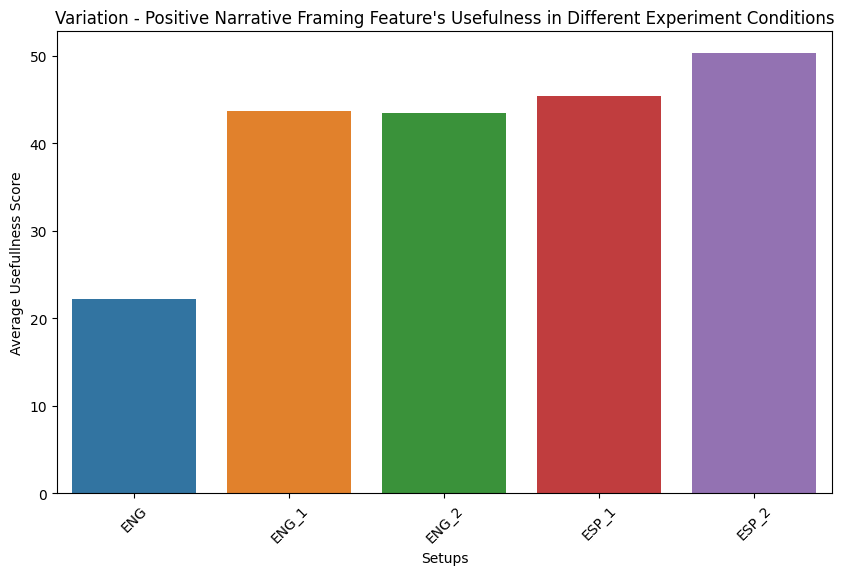

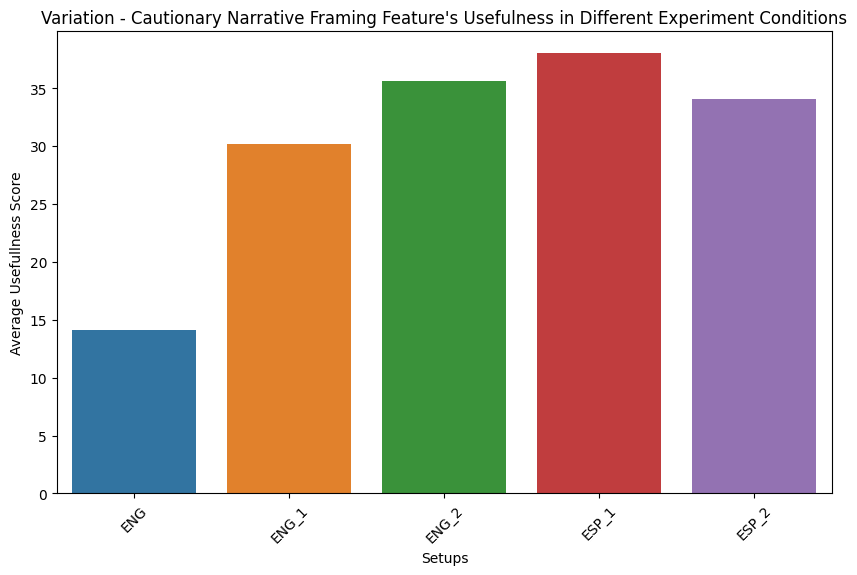

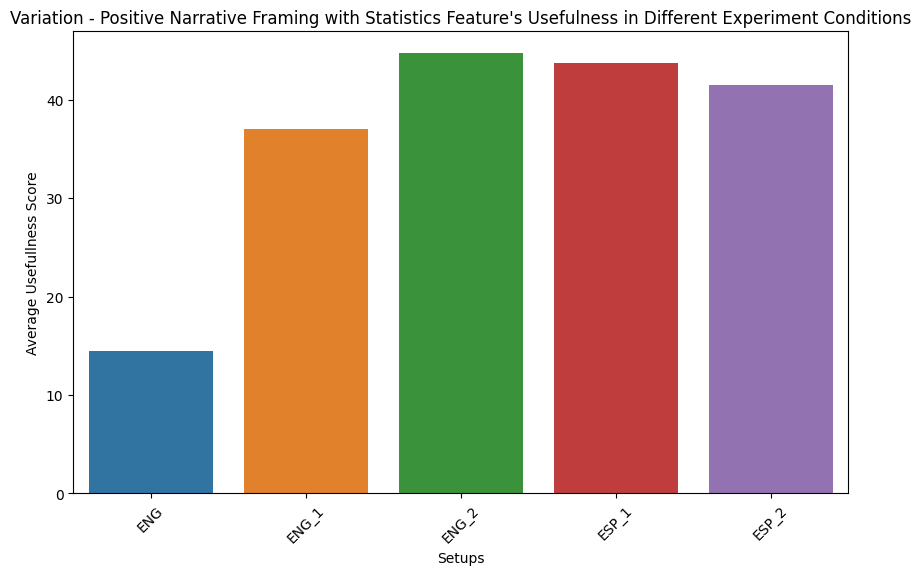

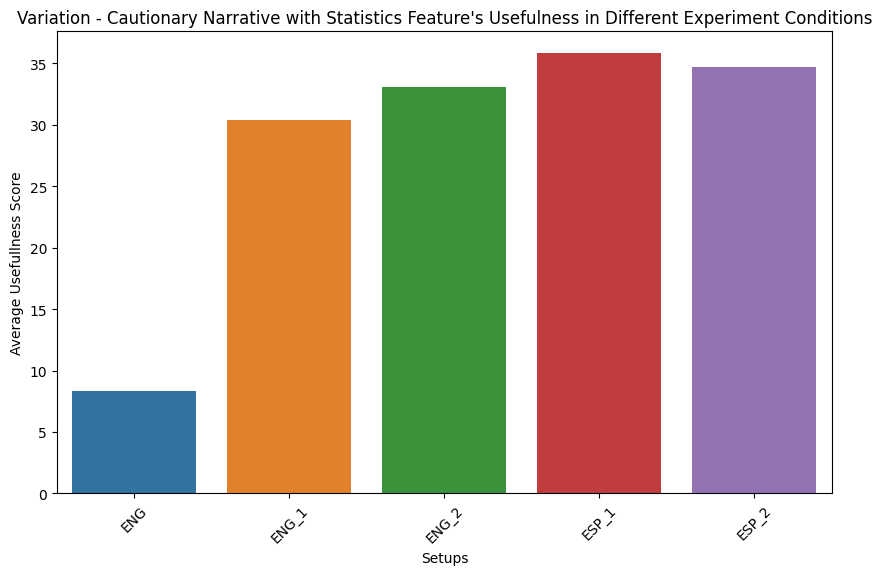

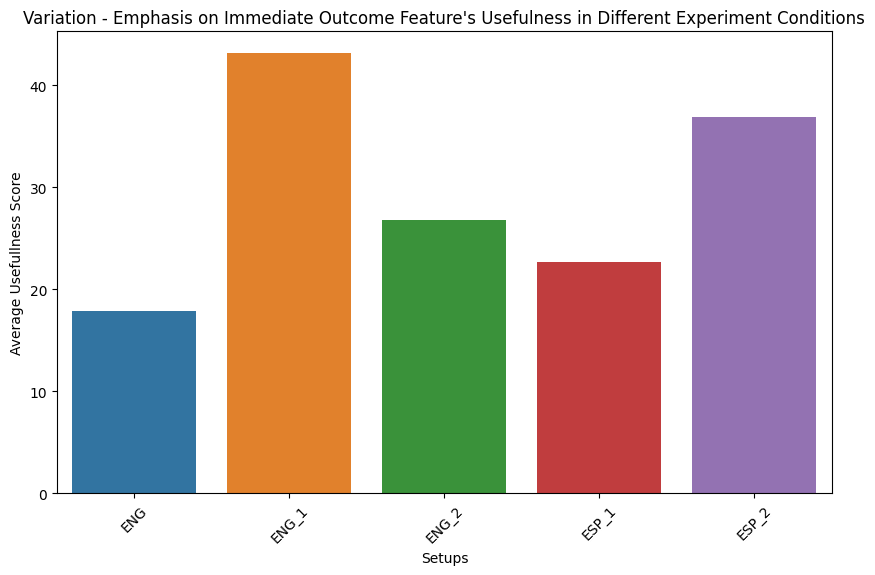

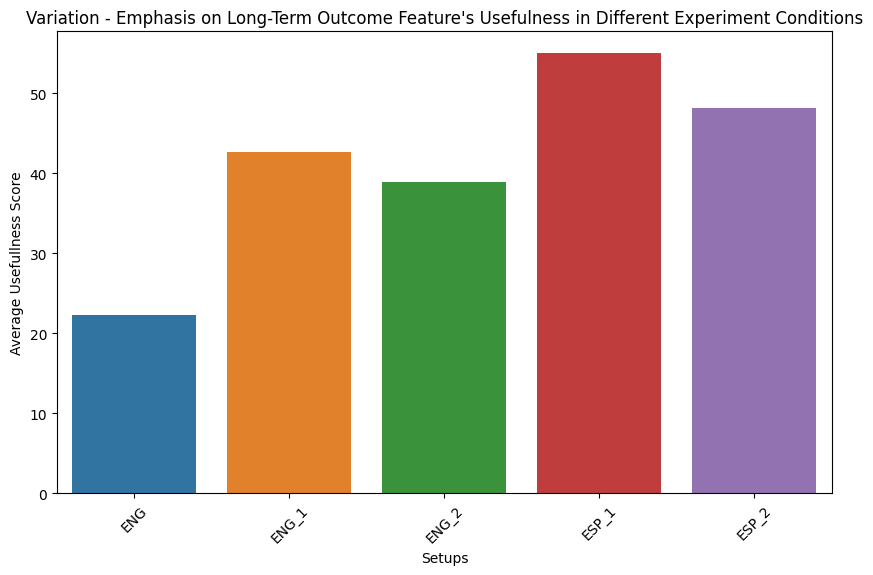

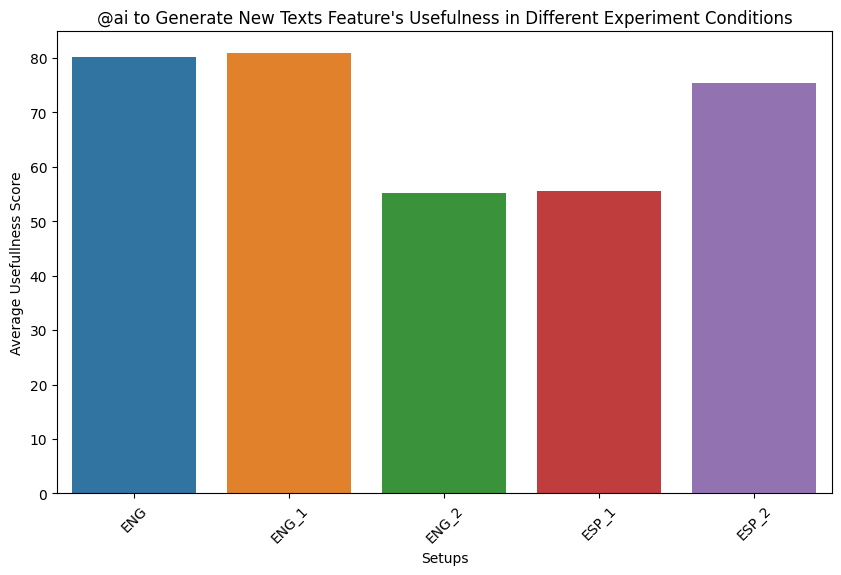

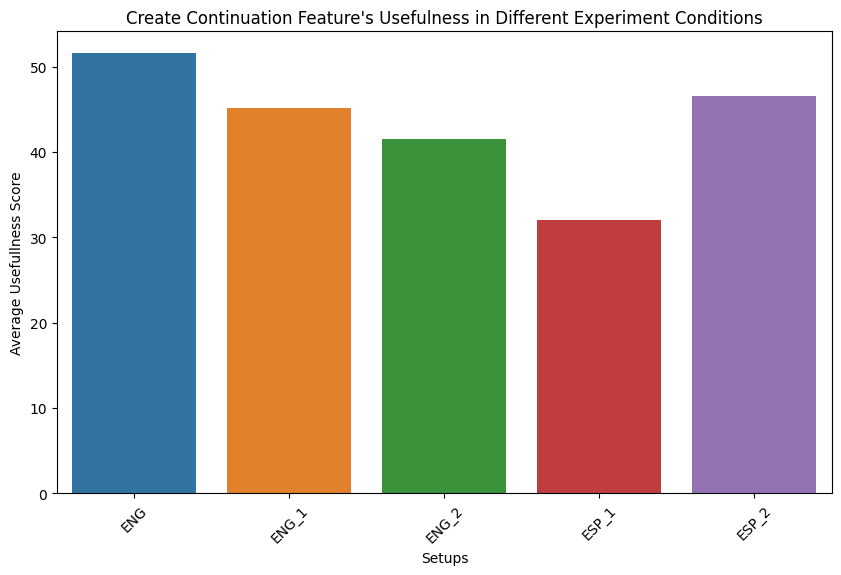

In [14]:
# List of feature columns
grouped_df = final_survey_df[features_task].groupby('TASK_ID').mean().reset_index()
grouped_df = grouped_df[grouped_df['TASK_ID']!='ENG_No_LLM']
# List of feature columns

# Create a graph for each feature
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='TASK_ID', y=feature, data=grouped_df, errorbar=None)
    plt.title(f'{feature_mapping.get(feature)} Feature\'s Usefulness in Different Experiment Conditions')
    plt.ylabel('Average Usefullness Score')
    plt.xlabel('Setups')
    plt.xticks(rotation=45)
    pdf_filename = f"{feature_mapping.get(feature)}_usefulness_plot.pdf"
    plt.savefig('../figures/results/'+pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()

# usefulness of features consolidated (all ai related features)

# usefulness of features normalized by count

In [15]:
master_activity_df['activity_log'] = master_activity_df['activity_log'].apply(ast.literal_eval)


In [16]:
master_activity_df = master_activity_df[master_activity_df['TASK_ID']!='ENG_No_LLM']

In [17]:
button_clicks_data = []

# Loop through each row in master_activity_df
for _, row in master_activity_df.iterrows():
    task_id = row['TASK_ID']
    activity_log = row['activity_log']
    study_id = row['study_id']
    # Extract buttonClicks from activity_log
    button_clicks = activity_log.get('buttonClicks', [])
    
    # Count the button click actions
    button_clicks_count = Counter([click['action'] for click in button_clicks])
    
    # Store the task_id and button_clicks_count in the list
    for action, count in button_clicks_count.items():
        button_clicks_data.append({
            'task_id': task_id,
            'study_id': study_id,
            'action': action,
            'count': count
        })

# Convert the list to a DataFrame
button_clicks_df = pd.DataFrame(button_clicks_data)

In [18]:
filter_out_actions = button_clicks_df[   
    ~button_clicks_df['action'].str.contains('CREATE VARIATION|DELETE CHUNK|DELETE VERSION')
]

In [19]:
filter_out_actions

,task_id,study_id,action,count
1,ENG,66c516b1d61c7b572205f713,recipe_Gain_Anecdotal,3
2,ENG,66c516b1d61c7b572205f713,recipe_LongTerm,1
4,ENG,66c516b1d61c7b572205f713,recipe_Loss_Statistics,1
5,ENG,66c516b1d61c7b572205f713,recipe_Gain_Statistics,2
6,ENG,66c516b1d61c7b572205f713,recipe_ShortTerm,1
...,...,...,...,...
355,ENG_2,66c63f502b78911af098063d,recipe_Loss_Anecdotal,1
356,ENG_2,66c63f502b78911af098063d,recipe_Gain_Statistics,1
357,ENG_2,66c63f502b78911af098063d,recipe_Loss_Statistics,1
358,ENG_2,66c63f502b78911af098063d,recipe_ShortTerm,1


In [20]:
allowed_actions = ['CREATE CONTINUATION', 'recipe_Gain_Anecdotal', 'recipe_Gain_Statistics',
                   'recipe_LongTerm', 'recipe_Loss_Anecdotal', 'recipe_Loss_Statistics',
                   'recipe_ShortTerm']

filter_out_actions.loc[:, 'filtered_action'] = filter_out_actions['action'].apply(
    lambda x: x if x in allowed_actions else 'custom'
)

C:\Users\shrey\AppData\Local\Temp\ipykernel_9836\700126712.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_out_actions.loc[:, 'filtered_action'] = filter_out_actions['action'].apply(


# count of actions from content usage

In [22]:
content_usage = master_activity_df.merge(master_documents_df[["_id",'content','word_count']], left_on='document_id', right_on='_id', how='inner').copy(deep=True)
# content_usage['activity_log'] = content_usage['activity_log'].apply(ast.literal_eval)


In [ ]:
content_usage.head(1)

,_id_x,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,_id_y,content,word_count
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,66c5a13c86c57a87db6f59d9,Join hands with us in protecting our planet's ...,176


In [23]:
content_usage['generated'] = content_usage['activity_log'].apply(lambda x: x['generatedContent'])

In [24]:
usage_count_data = []
for _, row in content_usage.iterrows():
    # plain_text = row['plain_text']
    generated_content = row['generated']
    task_id = row['TASK_ID']
    # for content in generated_content:
    counter = Counter(content.get('feature', 'custom recipe') for content in generated_content)
    for feat, cnt in counter.items():
        usage_count_data.append(
            {
                'task_id': task_id,
                'feature': feat,
                'count': cnt,
            }
        )
        
    # weighted_similarity = calculate_weighted_similarity(plain_text, generated_content, model)
    # weighted_similarity_results.append(weighted_similarity)

In [25]:
usage_count_df = pd.DataFrame(usage_count_data)
usage_count_df['feature'].unique()

array(['@ai generation', 'Positive Narrative Framing',
       'Emphasis on Long-Term Outcome',
       'Cautionary Narrative with Statistics',
       'Positive Narrative Framing with Statistics',
       'Emphasis on Immediate Outcome', 'Cautionary Narrative Framing',
       'continuation', 'newly created recipe', 'Emotional Manipulation',
       'custom recipe', 'Summary: ADD STATISTICS', 'Be More Emotional'],
      dtype=object)

In [26]:
usage_names_list = [
    "continuation",
    "@ai generation",
    "Positive Narrative Framing",
    "Cautionary Narrative Framing",
    "Positive Narrative Framing with Statistics",
    "Cautionary Narrative with Statistics",
    "Emphasis on Immediate Outcome",
    "Emphasis on Long-Term Outcome"
]

In [27]:
usage_count_df['feature_filtered'] = usage_count_df['feature'].apply(
    lambda x: x if x in usage_names_list else 'custom'
)

In [ ]:
usage_count_df.head()

,task_id,feature,count,feature_filtered
0,ENG,@ai generation,1,@ai generation
1,ENG,Positive Narrative Framing,3,Positive Narrative Framing
2,ENG,Emphasis on Long-Term Outcome,1,Emphasis on Long-Term Outcome
3,ENG,Cautionary Narrative with Statistics,1,Cautionary Narrative with Statistics
4,ENG,Positive Narrative Framing with Statistics,2,Positive Narrative Framing with Statistics


In [28]:
# aggregate_data = usage_count_df.groupby(['task_id', 'feature_filtered'])['count'].sum().reset_index()
usage_count_grouped = usage_count_df.groupby(['task_id', 'feature_filtered'])['count'].sum().reset_index()

In [29]:
usage_count_grouped

,task_id,feature_filtered,count
0,ENG,@ai generation,30
1,ENG,Cautionary Narrative Framing,12
2,ENG,Cautionary Narrative with Statistics,11
3,ENG,Emphasis on Immediate Outcome,13
4,ENG,Emphasis on Long-Term Outcome,18
5,ENG,Positive Narrative Framing,31
6,ENG,Positive Narrative Framing with Statistics,15
7,ENG,continuation,10
8,ENG,custom,4
9,ENG_1,@ai generation,28


In [35]:

fig = px.bar(
    usage_count_grouped, 
    x='task_id', 
    y='count', 
    color='feature_filtered',
    # hover_data={'filtered_action': True, 'count': True, 'filtered_action': True},
    # labels={'task_id': 'Task ID', 'count': 'Count', 'filtered_action': 'Action'},
    title='Button Clicks Count by Task ID',
    
)

# Customize the layout
fig.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Count',
    legend_title='Action',
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    width=1600,
    height=800
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the plot
fig.show()

## heatmap of count usage

In [36]:
usage_count_grouped_without_eng = usage_count_grouped[usage_count_grouped['task_id']!='ENG']
usage_count_grouped_without_eng = usage_count_grouped_without_eng[usage_count_grouped_without_eng['feature_filtered']!='custom']
heatmap_data_feature_usage = usage_count_grouped_without_eng.pivot(index="feature_filtered", columns="task_id", values="count")



In [38]:
fig = px.imshow(heatmap_data_feature_usage, 
                labels=dict(x="Task ID", y="Features", color="Count"),
                x=heatmap_data_feature_usage.columns,
                y=heatmap_data_feature_usage.index,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# # Adjust the figure size to match the Seaborn plot
fig.update_layout(title="Heatmap of Feature Counts by Task ID",
                  xaxis_title="Task ID",
                  yaxis_title="Features",
                  width=1200,  # Set width to match Seaborn
                  height=800,  # Set height to match Seaborn
                  margin=dict(l=80, r=80, t=100, b=80))  # Adjust margi
# Additionally, adjust the aspect ratio of the heatmap to avoid squishing
# fig.update_xaxes(scaleanchor="y", scaleratio=1)
# fig.update_yaxes(scaleanchor="x", scaleratio=1)
# fig.write_image("../figures/results/revealed_utility.png")

fig.show()

In [ ]:
fig.write_image("../figures/results/revealed_utility.pdf")

# heatmaps with count - stated usefulness

In [ ]:
usage_count_grouped_without_eng = usage_count_grouped[usage_count_grouped['task_id']!='ENG']
usage_count_grouped_without_eng

,task_id,feature_filtered,count
9,ENG_1,@ai generation,28
10,ENG_1,Cautionary Narrative Framing,9
11,ENG_1,Cautionary Narrative with Statistics,8
12,ENG_1,Emphasis on Immediate Outcome,12
13,ENG_1,Emphasis on Long-Term Outcome,10
14,ENG_1,Positive Narrative Framing,21
15,ENG_1,Positive Narrative Framing with Statistics,11
16,ENG_1,continuation,7
17,ENG_1,custom,10
18,ENG_2,@ai generation,10


In [ ]:
usage_count_grouped_without_eng = usage_count_grouped_without_eng[usage_count_grouped_without_eng['feature_filtered']!='custom']

In [ ]:
usage_count_grouped_without_eng['feature_filtered'].replace('continuation', 'Create Continuation', inplace=True)
usage_count_grouped_without_eng['feature_filtered'].replace('@ai generation', '@ai to Generate New Texts', inplace=True)

C:\Users\shrey\AppData\Local\Temp\ipykernel_2060\570960280.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shrey\AppData\Local\Temp\ipykernel_2060\570960280.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
usage_count_grouped_without_eng

,task_id,feature_filtered,count
9,ENG_1,@ai to Generate New Texts,28
10,ENG_1,Cautionary Narrative Framing,9
11,ENG_1,Cautionary Narrative with Statistics,8
12,ENG_1,Emphasis on Immediate Outcome,12
13,ENG_1,Emphasis on Long-Term Outcome,10
14,ENG_1,Positive Narrative Framing,21
15,ENG_1,Positive Narrative Framing with Statistics,11
16,ENG_1,Create Continuation,7
18,ENG_2,@ai to Generate New Texts,10
19,ENG_2,Cautionary Narrative Framing,7


In [ ]:
without_eng_usefulness

,TASK_ID,FEAT_1,FEAT_2,FEAT_3,FEAT_4,FEAT_5,FEAT_6,FEAT_7,FEAT_8
1,ENG_1,43.6875,30.1875,37.0000,30.3750,43.1250,42.6875,80.8125,45.1875
2,ENG_2,43.4375,35.6250,44.6875,33.0625,26.8125,38.9375,55.1250,41.5000
4,ESP_1,45.3750,38.0000,43.7500,35.8125,22.6875,55.0000,55.6250,32.0625
5,ESP_2,50.2500,34.0625,41.5000,34.6875,36.9375,48.1250,75.3750,46.5625


In [ ]:
usage_count_grouped_without_eng

,task_id,feature_filtered,count
9,ENG_1,@ai to Generate New Texts,28
10,ENG_1,Cautionary Narrative Framing,9
11,ENG_1,Cautionary Narrative with Statistics,8
12,ENG_1,Emphasis on Immediate Outcome,12
13,ENG_1,Emphasis on Long-Term Outcome,10
14,ENG_1,Positive Narrative Framing,21
15,ENG_1,Positive Narrative Framing with Statistics,11
16,ENG_1,Create Continuation,7
18,ENG_2,@ai to Generate New Texts,10
19,ENG_2,Cautionary Narrative Framing,7


In [ ]:
usage_count_grouped_without_eng.groupby('feature_filtered')['count'].sum()

feature_filtered
@ai to Generate New Texts                     74
Cautionary Narrative Framing                  27
Cautionary Narrative with Statistics          38
Create Continuation                           38
Emphasis on Immediate Outcome                 33
Emphasis on Long-Term Outcome                 40
Positive Narrative Framing                    59
Positive Narrative Framing with Statistics    38
Name: count, dtype: int64

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Average usefulness scores
grouped_df = pd.DataFrame({
    'TASK_ID': ['ENG_1', 'ENG_2', 'ESP_1', 'ESP_2'],
    'FEAT_1': [43.6875, 43.4375, 45.3750, 50.2500],
    'FEAT_2': [30.1875, 35.6250, 38.0000, 34.0625],
    'FEAT_3': [37.0000, 44.6875, 43.7500, 41.5000],
    'FEAT_4': [30.3750, 33.0625, 35.8125, 34.6875],
    'FEAT_5': [43.1250, 26.8125, 22.6875, 36.9375],
    'FEAT_6': [42.6875, 38.9375, 55.0000, 48.1250],
    'FEAT_7': [80.8125, 55.1250, 55.6250, 75.3750],
    'FEAT_8': [45.1875, 41.5000, 32.0625, 46.5625]
})

# Ensure TASK_ID is the first column when reordering
task_id_column = grouped_df.pop('TASK_ID')

# Feature usage counts
feature_usage_count = {
    "Pos. Narrative": 59,
    "Caut. Narrative": 27,
    "Pos. Narrative + Stats": 38,
    "Caut. Narrative + Stats": 38,
    "Immediate Outcome": 33,
    "Long-Term Outcome": 40,
    "@ai Text Gen": 74,
    "Create Continuation": 38
}

# Short labels for the features, including counts
short_labels_with_counts = {
    "FEAT_1": f"Pos. Narrative ({feature_usage_count['Pos. Narrative']})",
    "FEAT_2": f"Caut. Narrative ({feature_usage_count['Caut. Narrative']})",
    "FEAT_3": f"Pos. Narrative + Stats ({feature_usage_count['Pos. Narrative + Stats']})",
    "FEAT_4": f"Caut. Narrative + Stats ({feature_usage_count['Caut. Narrative + Stats']})",
    "FEAT_5": f"Immediate Outcome ({feature_usage_count['Immediate Outcome']})",
    "FEAT_6": f"Long-Term Outcome ({feature_usage_count['Long-Term Outcome']})",
    "FEAT_7": f"@ai Text Gen ({feature_usage_count['@ai Text Gen']})",
    "FEAT_8": f"Create Continuation ({feature_usage_count['Create Continuation']})"
}

# Create a mapping from FEAT_X to the corresponding full feature name for sorting
feat_to_full_name = {
    "FEAT_1": "Pos. Narrative",
    "FEAT_2": "Caut. Narrative",
    "FEAT_3": "Pos. Narrative + Stats",
    "FEAT_4": "Caut. Narrative + Stats",
    "FEAT_5": "Immediate Outcome",
    "FEAT_6": "Long-Term Outcome",
    "FEAT_7": "@ai Text Gen",
    "FEAT_8": "Create Continuation"
}

# Sort the features by their counts in descending order
sorted_features = sorted(short_labels_with_counts.keys(), 
                         key=lambda x: feature_usage_count[feat_to_full_name[x]], 
                         reverse=True)

# Reorder the columns in the dataframe based on sorted features
grouped_df_sorted = pd.concat([task_id_column, grouped_df[sorted_features]], axis=1)

# Rename the columns with the short labels and counts
grouped_df_sorted = grouped_df_sorted.rename(columns=short_labels_with_counts)

# Create a heatmap
heatmap_data = grouped_df_sorted.set_index('TASK_ID').T


### SNS

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap='coolwarm', linewidths=.5)
plt.title("Summary of Feature Usefulness Across Different Experimental Conditions")
plt.xlabel("Experiment Conditions")
plt.ylabel("Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)  # Keep y-labels horizontal for readability

# Save the plot as a PDF (optional)
pdf_filename = "perceived_usefulness_with_count.pdf"
plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')

plt.show()

TASK_ID,ENG_1,ENG_2,ESP_1,ESP_2
@ai Text Gen (74),80.8125,55.1250,55.6250,75.3750
Pos. Narrative (59),43.6875,43.4375,45.3750,50.2500
Long-Term Outcome (40),42.6875,38.9375,55.0000,48.1250
Pos. Narrative + Stats (38),37.0000,44.6875,43.7500,41.5000
Caut. Narrative + Stats (38),30.3750,33.0625,35.8125,34.6875
Create Continuation (38),45.1875,41.5000,32.0625,46.5625
Immediate Outcome (33),43.1250,26.8125,22.6875,36.9375
Caut. Narrative (27),30.1875,35.6250,38.0000,34.0625


### Plotly

In [60]:
fig = px.imshow(heatmap_data, 
                labels=dict(x="Task ID", y="Features", color="Count"),
                x=heatmap_data.columns,
                y=heatmap_data.index,
                color_continuous_scale="YlGnBu",
                text_auto=True,
                aspect='auto')

# # Adjust the figure size to match the Seaborn plot
fig.update_layout(title="Heatmap of Feature Counts by Task ID",
                  xaxis_title="Task ID",
                  yaxis_title="Features",
                  width=1200,  # Set width to match Seaborn
                  height=800,  # Set height to match Seaborn
                  margin=dict(l=80, r=80, t=100, b=80))  # Adjust margi
# Additionally, adjust the aspect ratio of the heatmap to avoid squishing
# fig.update_xaxes(scaleanchor="y", scaleratio=1)
# fig.update_yaxes(scaleanchor="x", scaleratio=1)
# fig.write_image("../figures/results/revealed_utility.png")

fig.show()

In [34]:
fig.write_image('../figures/results/perceived_usefulness_with_count_test.pdf')

# Actions performed in between ai feature called

In [ ]:
from datetime import datetime, timedelta
from collections import defaultdict


In [ ]:
key_logs = master_activity_df.copy(deep=True)
key_logs['key_logs'] = master_activity_df['activity_log'].apply(lambda x:x['keyLogs'])
key_logs.head(2)

,_id,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,key_logs
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Shift', 'timestamp': '2024-08-21T08:..."
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Backspace', 'timestamp': '2024-08-21..."


In [ ]:
key_logs['generated_content'] = master_activity_df['activity_log'].apply(lambda x:x['generatedContent'])

In [ ]:
key_logs

,_id,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,key_logs,generated_content
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Shift', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': 'writ..."
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Backspace', 'timestamp': '2024-08-21...",[{'feature': 'Cautionary Narrative with Statis...
2,66c5a2ec86c57a87db6f59ed,66c5a21086c57a87db6f59e1,main_task_1,5c62de3f48fe4e000180e09d,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:18:52.061000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Shift', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': 'plea..."
3,66c88800e46942c099b32394,66c88773e46942c099b32393,main_task_1,5d1f9776676cd1001580ae9c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-23 13:00:48.591000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Control', 'timestamp': '2024-08-23T1...","[{'feature': '@ai generation', 'prompt': 'use ..."
4,66c5a5c486c57a87db6f5a00,66c5a3e386c57a87db6f59f9,main_task_1,5ea9a41b87b4150bf9634637,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:31:00.305000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Enter', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': ' ﻿Wr..."
...,...,...,...,...,...,...,...,...,...,...,...
75,66c7208e6db9c208f260cb6b,66c71e1a6db9c208f260cb58,main_task_1,66ad3809e453f7b457f7d048,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 11:27:10.356000+00:00,66c63f502b78911af098063d,ENG_2,"[{'key': 'Backspace', 'timestamp': '2024-08-22...","[{'feature': '@ai generation', 'prompt': 'writ..."
76,66c74f856db9c208f260cc0f,66c74f216db9c208f260cc0c,main_task_2,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 14:47:33.899000+00:00,66c63f502b78911af098063d,ESP_1,"[{'key': 'Shift', 'timestamp': '2024-08-22T14:...","[{'feature': '@ai generation', 'prompt': 'crea..."
77,66c7519f6db9c208f260cc1c,66c750f16db9c208f260cc18,main_task_1,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE CONTINUAT...,0,2024-08-22 14:56:31.836000+00:00,66c63f502b78911af098063d,ENG_2,"[{'key': 'Shift', 'timestamp': '2024-08-22T14:...","[{'feature': 'continuation', 'prompt': 'Suppor..."
78,66c758d46db9c208f260cc33,66c757f06db9c208f260cc32,main_task_2,6549030c68f0146d7216bb1c,"{'buttonClicks': [], 'generatedContent': [], '...",0,2024-08-22 15:27:16.063000+00:00,66c63f502b78911af098063d,ESP_1,"[{'key': 'Meta', 'timestamp': '2024-08-22T15:2...",[]


In [ ]:
rows = []

# Iterate over each document and its sorted events
for _, row in key_logs.iterrows():
    doc_id = row['document_id']
    task_id = row['TASK_ID']
    key_strokes = row['key_logs']
    feature_usg = row['generated_content']
    
    # Collect all key press events for the document
    for stroke in key_strokes:
        rows.append({
            'doc_id': doc_id,
            'task_id': task_id,
            'event_type': 'key',
            'content': stroke['key'],
            'timestamp': datetime.fromisoformat(stroke['timestamp'].replace('Z', '+00:00'))
        })
    
    # Collect all feature usage events for the document
    for content in feature_usg:
        rows.append({
            'doc_id': doc_id,
            'task_id': task_id,
            'event_type': content['feature'] if 'feature' in content else 'custom',
            'content': content['response'],
            'timestamp': datetime.fromisoformat(content['timestamp'].replace('Z', '+00:00'))
        })

# Convert the list of rows into a DataFrame
keylog_df = pd.DataFrame(rows)

# Sort the DataFrame by document ID and timestamp to ensure the order is correct
keylog_df.sort_values(by=['doc_id', 'timestamp'], inplace=True)
keylog_df.reset_index(drop=True, inplace=True)


In [ ]:
keylog_df['event_type'].unique()

array(['key', '@ai generation', 'Emphasis on Long-Term Outcome',
       'Emphasis on Immediate Outcome',
       'Cautionary Narrative with Statistics',
       'Positive Narrative Framing with Statistics',
       'Cautionary Narrative Framing', 'Positive Narrative Framing',
       'continuation', 'newly created recipe', 'custom',
       'Be More Emotional', 'Summary: ADD STATISTICS',
       'Emotional Manipulation'], dtype=object)

In [ ]:
outside_standard_recipe = ['Be More Emotional', 'newly created recipe', 'Be More Emotional', 'Summary: ADD STATISTICS', 'Emotional Manipulation']
keylog_df['event_type'] = keylog_df['event_type'].apply(lambda x: x if x not in outside_standard_recipe else 'custom')

In [ ]:
keylog_df

,doc_id,task_id,event_type,content,timestamp
0,66c522869236da2225cc8cf2,ENG,key,Shift,2024-08-20 23:11:10.701000+00:00
1,66c522869236da2225cc8cf2,ENG,key,@,2024-08-20 23:11:10.893000+00:00
2,66c522869236da2225cc8cf2,ENG,key,a,2024-08-20 23:11:11.345000+00:00
3,66c522869236da2225cc8cf2,ENG,key,i,2024-08-20 23:11:11.502000+00:00
4,66c522869236da2225cc8cf2,ENG,key,,2024-08-20 23:11:11.793000+00:00
...,...,...,...,...,...
34251,66d3ca8a5a434c9ed85a685a,ENG_2,key,Backspace,2024-09-01 02:01:06.282000+00:00
34252,66d3ca8a5a434c9ed85a685a,ENG_2,key,,2024-09-01 02:01:06.762000+00:00
34253,66d3ca8a5a434c9ed85a685a,ENG_2,key,,2024-09-01 02:01:53.113000+00:00
34254,66d3ca8a5a434c9ed85a685a,ENG_2,key,Control,2024-09-01 02:01:53.369000+00:00


In [ ]:

key_logs['combined_logs'] = key_logs.apply(lambda x: x['key_logs'] + x['generated_content'], axis=1)
key_logs

,_id,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,key_logs,generated_content,combined_logs
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Shift', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': 'writ...","[{'key': 'Shift', 'timestamp': '2024-08-21T08:..."
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Backspace', 'timestamp': '2024-08-21...",[{'feature': 'Cautionary Narrative with Statis...,"[{'key': 'Backspace', 'timestamp': '2024-08-21..."
2,66c5a2ec86c57a87db6f59ed,66c5a21086c57a87db6f59e1,main_task_1,5c62de3f48fe4e000180e09d,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:18:52.061000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Shift', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': 'plea...","[{'key': 'Shift', 'timestamp': '2024-08-21T08:..."
3,66c88800e46942c099b32394,66c88773e46942c099b32393,main_task_1,5d1f9776676cd1001580ae9c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-23 13:00:48.591000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Control', 'timestamp': '2024-08-23T1...","[{'feature': '@ai generation', 'prompt': 'use ...","[{'key': 'Control', 'timestamp': '2024-08-23T1..."
4,66c5a5c486c57a87db6f5a00,66c5a3e386c57a87db6f59f9,main_task_1,5ea9a41b87b4150bf9634637,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:31:00.305000+00:00,66c516b1d61c7b572205f713,ENG,"[{'key': 'Enter', 'timestamp': '2024-08-21T08:...","[{'feature': '@ai generation', 'prompt': ' ﻿Wr...","[{'key': 'Enter', 'timestamp': '2024-08-21T08:..."
...,...,...,...,...,...,...,...,...,...,...,...,...
75,66c7208e6db9c208f260cb6b,66c71e1a6db9c208f260cb58,main_task_1,66ad3809e453f7b457f7d048,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 11:27:10.356000+00:00,66c63f502b78911af098063d,ENG_2,"[{'key': 'Backspace', 'timestamp': '2024-08-22...","[{'feature': '@ai generation', 'prompt': 'writ...","[{'key': 'Backspace', 'timestamp': '2024-08-22..."
76,66c74f856db9c208f260cc0f,66c74f216db9c208f260cc0c,main_task_2,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 14:47:33.899000+00:00,66c63f502b78911af098063d,ESP_1,"[{'key': 'Shift', 'timestamp': '2024-08-22T14:...","[{'feature': '@ai generation', 'prompt': 'crea...","[{'key': 'Shift', 'timestamp': '2024-08-22T14:..."
77,66c7519f6db9c208f260cc1c,66c750f16db9c208f260cc18,main_task_1,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE CONTINUAT...,0,2024-08-22 14:56:31.836000+00:00,66c63f502b78911af098063d,ENG_2,"[{'key': 'Shift', 'timestamp': '2024-08-22T14:...","[{'feature': 'continuation', 'prompt': 'Suppor...","[{'key': 'Shift', 'timestamp': '2024-08-22T14:..."
78,66c758d46db9c208f260cc33,66c757f06db9c208f260cc32,main_task_2,6549030c68f0146d7216bb1c,"{'buttonClicks': [], 'generatedContent': [], '...",0,2024-08-22 15:27:16.063000+00:00,66c63f502b78911af098063d,ESP_1,"[{'key': 'Meta', 'timestamp': '2024-08-22T15:2...",[],"[{'key': 'Meta', 'timestamp': '2024-08-22T15:2..."


In [ ]:
key_logs = key_logs[key_logs['TASK_ID']!='ENG_No_LLM']

In [ ]:
def ensure_feature_key(content_list):
    for content in content_list:
        if 'feature' not in content:
            content['feature'] = 'custom_recipe'
        if 'feature' in content and content['feature'] in outside_standard_recipe:
            content['feature'] = 'custom_recipe'
    return content_list

# Apply the function to the 'generated_content' column
key_logs['generated_content'] = key_logs['generated_content'].apply(ensure_feature_key)


In [ ]:
key_logs['combined_logs_sorted'] = key_logs['combined_logs'].apply(
    lambda logs: sorted(logs, key=lambda x: x['timestamp'])
)

In [ ]:
def process_logs(logs):
    key_counter = Counter()
    results = []
    prev_action = "START"

    for log in logs:
        if 'key' in log:
            # Count the key presses
            key_counter[log['key']] += 1
        else:
            if 'feature' in log:
            # When a feature is encountered, save the results from START to this feature
                results.append({
                    'from_action': prev_action,
                    'to_action': log['feature'],
                    'key_counts': dict(key_counter)
                })
                # Reset the counter and update the previous action
                key_counter = Counter()
                prev_action = log['feature']
            else:
                results.append({
                    'from_action': prev_action,
                    'to_action': 'custom_recipe',
                    'key_counts': dict(key_counter)
                })
                # Reset the counter and update the previous action
                key_counter = Counter()
                prev_action = 'custom_recipe'
                
        
    
    # Capture the final set of key presses up to the last feature
    results.append({
        'from_action': prev_action,
        'to_action': "END",
        'key_counts': dict(key_counter)
    })
    
    return results

In [ ]:


# Apply the process_logs function to the combined_logs_sorted column
key_logs['processed_logs'] = key_logs['combined_logs_sorted'].apply(process_logs)

# Flatten the processed logs into a DataFrame for easier analysis
flattened_results = []

for _, row in key_logs.iterrows():
    doc_id = row['document_id']
    task_id = row['TASK_ID']
    for entry in row['processed_logs']:
        flattened_results.append({
            'doc_id': doc_id,
            'task_id': task_id,
            'from_action': entry['from_action'],
            'to_action': entry['to_action'],
            'key_counts': entry['key_counts']
        })

# Convert the flattened results into a DataFrame
final_key_logs = pd.DataFrame(flattened_results)

In [ ]:
final_key_logs

,doc_id,task_id,from_action,to_action,key_counts
0,66c5a13c86c57a87db6f59d9,ENG,START,@ai generation,"{'Shift': 3, '@': 1, 'a': 3, 'i': 2, ' ': 5, '..."
1,66c5a13c86c57a87db6f59d9,ENG,@ai generation,Positive Narrative Framing,"{' ': 12, 'Backspace': 21, 'Enter': 3, ',': 3,..."
2,66c5a13c86c57a87db6f59d9,ENG,Positive Narrative Framing,Positive Narrative Framing,{}
3,66c5a13c86c57a87db6f59d9,ENG,Positive Narrative Framing,Positive Narrative Framing,"{'.': 1, 'Enter': 1}"
4,66c5a13c86c57a87db6f59d9,ENG,Positive Narrative Framing,Emphasis on Long-Term Outcome,"{'.': 1, 'Enter': 1}"
...,...,...,...,...,...
602,66c750f16db9c208f260cc18,ENG_2,Emphasis on Long-Term Outcome,Positive Narrative Framing,{}
603,66c750f16db9c208f260cc18,ENG_2,Positive Narrative Framing,@ai generation,"{'Enter': 5, 'Backspace': 3, 'Shift': 1, '@': ..."
604,66c750f16db9c208f260cc18,ENG_2,@ai generation,END,{}
605,66c757f06db9c208f260cc32,ESP_1,START,END,"{'Meta': 4, 'c': 1, 'Backspace': 5, 'v': 2, 'z..."


In [ ]:
final_key_logs[final_key_logs['doc_id']=='66c88f79e46942c099b323a7']

,doc_id,task_id,from_action,to_action,key_counts
110,66c88f79e46942c099b323a7,ENG,START,@ai generation,"{'Backspace': 79, 'Shift': 2, '@': 1, 'a': 5, ..."
111,66c88f79e46942c099b323a7,ENG,@ai generation,Positive Narrative Framing with Statistics,"{'Backspace': 69, ' ': 1}"
112,66c88f79e46942c099b323a7,ENG,Positive Narrative Framing with Statistics,Cautionary Narrative Framing,{}
113,66c88f79e46942c099b323a7,ENG,Cautionary Narrative Framing,custom_recipe,{}
114,66c88f79e46942c099b323a7,ENG,custom_recipe,continuation,"{'CapsLock': 2, 'Y': 1, 'o': 2, 'u': 2, 'r': 2..."
115,66c88f79e46942c099b323a7,ENG,continuation,Emphasis on Immediate Outcome,{}
116,66c88f79e46942c099b323a7,ENG,Emphasis on Immediate Outcome,custom_recipe,{}
117,66c88f79e46942c099b323a7,ENG,custom_recipe,END,{}


In [ ]:
final_key_logs[final_key_logs['doc_id']=='66c6181507bfd712ba618584']

,doc_id,task_id,from_action,to_action,key_counts
160,66c6181507bfd712ba618584,ENG_1,START,Positive Narrative Framing,"{'Backspace': 1, 'Meta': 1, 'v': 1}"
161,66c6181507bfd712ba618584,ENG_1,Positive Narrative Framing,custom_recipe,{}
162,66c6181507bfd712ba618584,ENG_1,custom_recipe,Positive Narrative Framing,{}
163,66c6181507bfd712ba618584,ENG_1,Positive Narrative Framing,Positive Narrative Framing,{}
164,66c6181507bfd712ba618584,ENG_1,Positive Narrative Framing,custom_recipe,{}
165,66c6181507bfd712ba618584,ENG_1,custom_recipe,custom_recipe,"{'Escape': 1, 'Enter': 1, 'Meta': 1, 'v': 1}"
166,66c6181507bfd712ba618584,ENG_1,custom_recipe,custom_recipe,{}
167,66c6181507bfd712ba618584,ENG_1,custom_recipe,custom_recipe,{}
168,66c6181507bfd712ba618584,ENG_1,custom_recipe,custom_recipe,"{'Shift': 1, ']': 1, '[': 1}"
169,66c6181507bfd712ba618584,ENG_1,custom_recipe,END,{}


In [ ]:
len(final_key_logs.iloc[0]['key_counts'].keys())

17

In [ ]:
# def count_actions(row):
#     # print(row)
#     count = 0
#     for action, counts in row.items():
#         # if action == 'Backspace':
#         count += 1
    
#     return count

final_key_logs['all_action_count'] = final_key_logs['key_counts'].apply(lambda x: len(x.keys()))

In [ ]:
final_key_logs['all_action_count']

0      17
1      14
2       0
3       2
4       2
       ..
602     0
603    20
604     0
605     6
606     5
Name: all_action_count, Length: 607, dtype: int64

In [ ]:
final_key_logs['all_action_count'].replace(np.nan, 0, inplace=True)

In [ ]:
aggregate_data_keylogs = final_key_logs.groupby(['task_id','from_action'])['all_action_count'].sum().reset_index()
aggregate_data_keylogs = aggregate_data_keylogs[aggregate_data_keylogs['from_action']!='START']
aggregate_data_keylogs.head(2)

,task_id,from_action,all_action_count
0,ENG,@ai generation,268
1,ENG,Cautionary Narrative Framing,22


In [ ]:
fig = px.bar(
    aggregate_data_keylogs, 
    x='task_id', 
    y='all_action_count', 
    color='from_action',
    # hover_data={'feature_filtered': True, 'count': True, 'feature_filtered': True},
    # labels={'task_id': 'Task ID', 'count': 'Count', 'filtered_action': 'feature_filtered'},
    title='Action in between feature usage by Task ID',
    # histfunc='sum'
)

# Customize the layout
fig.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Count',
    legend_title='Action',
    barmode='group',
    bargap=0.15,
    bargroupgap=0.1,
    width=1600,
    height=800
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=45)

# Show the plot
fig.show()

# AI generated content similarity

In [40]:
from sentence_transformers import SentenceTransformer
import ollama
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\shrey\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [41]:
sentence_transformer_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')


In [42]:
def sentence_transformer_embed_text(prompt):
    return sentence_transformer_model.encode([prompt])


# Placeholder functions to simulate embedding generation for hypothetical models
def nomic_embed_text(prompt):
    text = ollama.embeddings(model='nomic-embed-text', prompt=prompt,)
    return np.array(text['embedding']).reshape(1, -1)

def mxbai_embed_large(prompt):
    text = ollama.embeddings(model='mxbai-embed-large', prompt=prompt,)
    return np.array(text['embedding']).reshape(1, -1)

In [43]:
# Step 3: Define the models and their corresponding embedding functions
models = {
    'SentenceTransformer': sentence_transformer_embed_text,
    'nomic-embed-text': nomic_embed_text,
    'mxbai-embed-large': mxbai_embed_large,
}

In [ ]:
# Step 3: Define the models and their corresponding embedding functions
models = {
    'SentenceTransformer': sentence_transformer_embed_text,
    'nomic-embed-text': nomic_embed_text,
    'mxbai-embed-large': mxbai_embed_large,
}

results = []

for model_name, embed_function in models.items():
    average_similarity_results = []
    weighted_similarity_results = []
    
    for _, row in content_usage.iterrows():
        plain_text = row['plain_text']
        generated_content = row['generated']
        
        # Average similarity
        avg_similarity = calculate_average_similarity(plain_text, generated_content, embed_function)
        average_similarity_results.append(avg_similarity)
        
        # Weighted average similarity
        weighted_similarity = calculate_weighted_average_similarity(plain_text, generated_content, embed_function)
        weighted_similarity_results.append(weighted_similarity)
    
    # Store results in the DataFrame
    content_usage[f'average_similarity_{model_name}'] = average_similarity_results
    content_usage[f'weighted_similarity_{model_name}'] = weighted_similarity_results

# Step 4: Plot the results

for model_name in models.keys():
    # Group by TASK_ID for both average and weighted similarities
    grouped_avg_similarity = content_usage.groupby('TASK_ID')[f'average_similarity_{model_name}'].mean().reset_index()
    grouped_weighted_similarity = content_usage.groupby('TASK_ID')[f'weighted_similarity_{model_name}'].mean().reset_index()
    
    # Plot Average Similarity
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TASK_ID', y=f'average_similarity_{model_name}', data=grouped_avg_similarity, errorbar="sd")
    plt.title(f'Average AI-Generated Response Similarity by Task ID ({model_name})')
    plt.ylabel('Average Similarity Percentage (%)')
    plt.xlabel('Task ID')
    plt.xticks(rotation=45)
    plt.show()
    
    # Plot Weighted Average Similarity
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TASK_ID', y=f'weighted_similarity_{model_name}', data=grouped_weighted_similarity, errorbar="sd")
    plt.title(f'Weighted Average AI-Generated Response Similarity by Task ID ({model_name})')
    plt.ylabel('Weighted Average Similarity Percentage (%)')
    plt.xlabel('Task ID')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
avg_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'average_similarity_SentenceTransformer',
        'average_similarity_nomic-embed-text',
        'average_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Average Similarity (%)'
)

# Melt the DataFrame to long format for weighted average similarity
weighted_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'weighted_similarity_SentenceTransformer',
        'weighted_similarity_nomic-embed-text',
        'weighted_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Weighted Average Similarity (%)'
)

# Clean up the 'Model' column to only contain the model names

avg_similarity_df['Model'] = avg_similarity_df['Model'].str.replace('average_similarity_', '')
weighted_similarity_df['Model'] = weighted_similarity_df['Model'].str.replace('weighted_similarity_', '')


avg_similarity_df =  avg_similarity_df[avg_similarity_df['TASK_ID']!='ENG_No_LLM']
weighted_similarity_df =  weighted_similarity_df[weighted_similarity_df['TASK_ID']!='ENG_No_LLM']

avg_similarity_df = avg_similarity_df.groupby(['TASK_ID','Model'])['Average Similarity (%)'].mean().reset_index()
weighted_similarity_df = weighted_similarity_df.groupby(['TASK_ID','Model'])['Weighted Average Similarity (%)'].mean().reset_index()

# Step 2: Plot using Plotly

# Plot Average Similarity
fig_avg = px.bar(
    avg_similarity_df,
    x='TASK_ID',
    y='Average Similarity (%)',
    color='Model',
    title='Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group'
)
fig_avg.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_avg.show()

# Plot Weighted Average Similarity
fig_weighted = px.bar(
    weighted_similarity_df,
    x='TASK_ID',
    y='Weighted Average Similarity (%)',
    color='Model',
    title='Weighted Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group'
)
fig_weighted.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Weighted Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_weighted.show()


### Method 1: Simple Average Similarity

This method calculates the average cosine similarity between the AI-generated content and the final text for each `task_id`.

**Formula:**

$$
\text{Average Similarity} = \frac{1}{n} \sum_{i=1}^{n} \text{cosine\_similarity}(F_i, F)
$$

Where:
- \( n \) is the number of AI-generated segments.
- $ F_i $ is the embedding for the AI-generated segment.
- \( F \) is the embedding for the final document.


In [44]:
def calculate_average_similarity(plain_text, generated_content, embed_function):
    plain_text_embedding = embed_function(plain_text)
    
    similarities = []
    for content in generated_content:
        response = content.get('response')
        if response:
            response_embedding = embed_function(response)
            similarity = cosine_similarity(plain_text_embedding, response_embedding)[0][0]
            similarities.append(similarity)
    
    if similarities:
        return np.mean(similarities) * 100  # Convert to percentage
    else:
        return 0


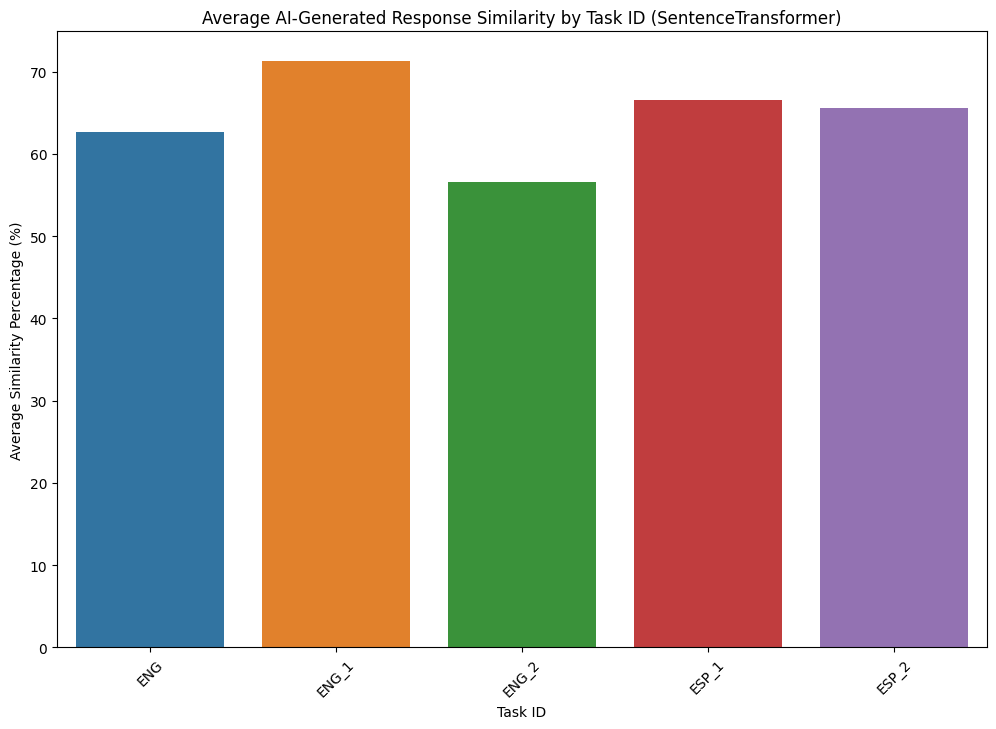

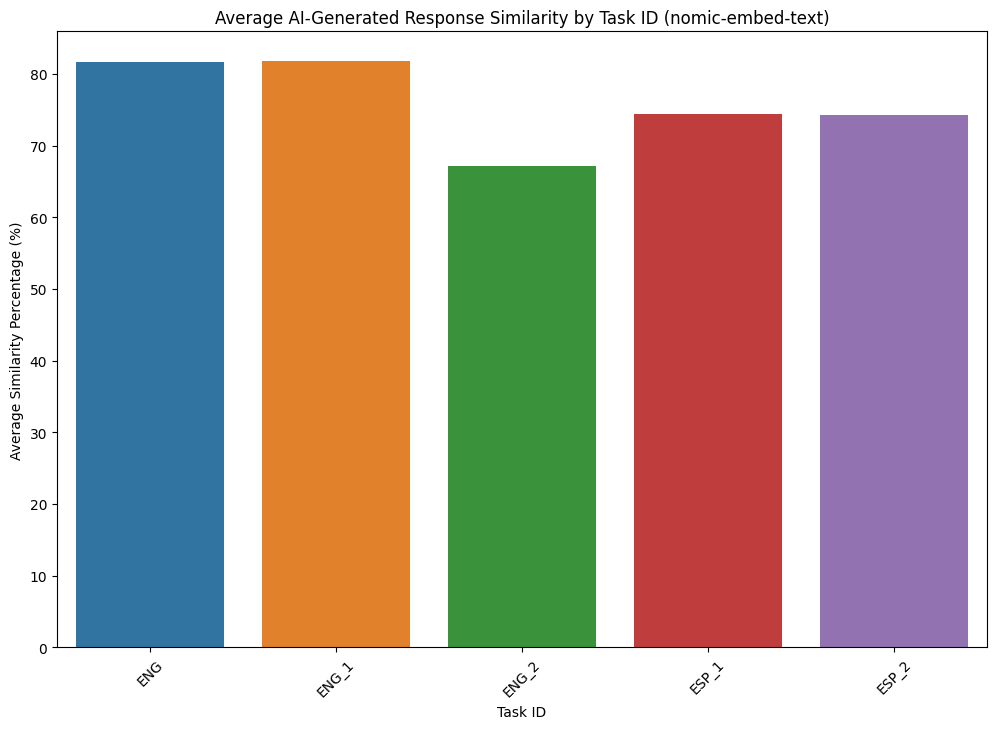

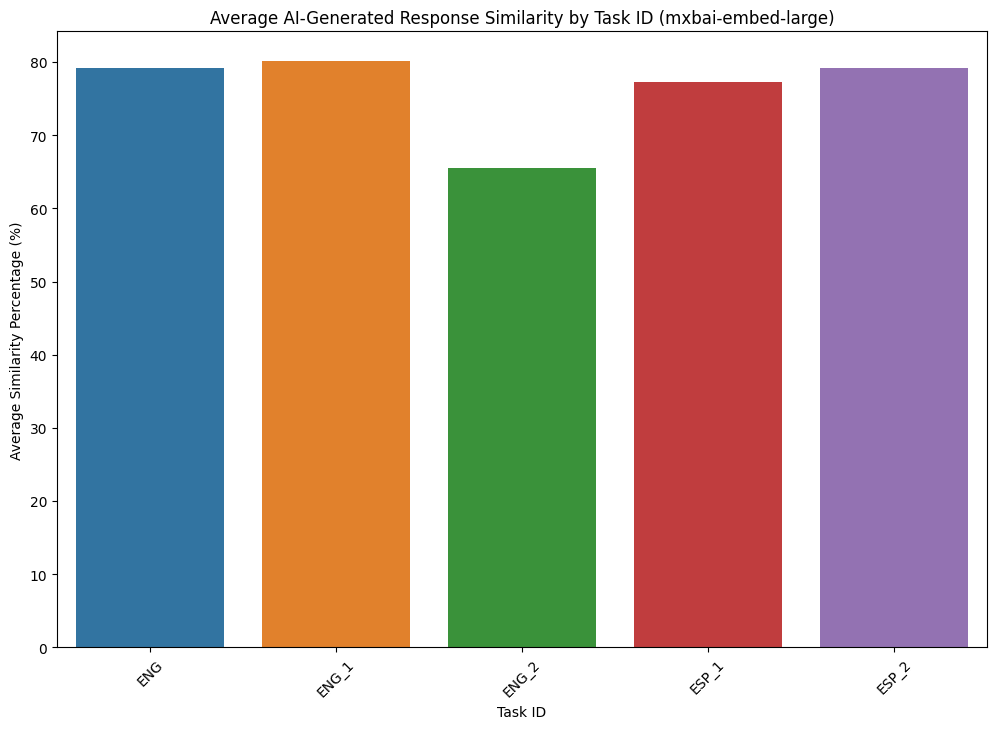

In [ ]:
# results_avg = []

for model_name, embed_function in models.items():
    average_similarity_results = []
    # weighted_similarity_results = []
    
    for _, row in content_usage.iterrows():
        plain_text = row['content']
        generated_content = row['generated']
        
        # Average similarity
        avg_similarity = calculate_average_similarity(plain_text, generated_content, embed_function)
        average_similarity_results.append(avg_similarity)
        
    
    # Store results in the DataFrame
    content_usage[f'average_similarity_{model_name}'] = average_similarity_results
    # content_usage[f'weighted_similarity_{model_name}'] = weighted_similarity_results

# Step 4: Plot the results

for model_name in models.keys():
    # Group by TASK_ID for both average and weighted similarities
    grouped_avg_similarity = content_usage.groupby('TASK_ID')[f'average_similarity_{model_name}'].mean().reset_index()
    # grouped_weighted_similarity = content_usage.groupby('TASK_ID')[f'weighted_similarity_{model_name}'].mean().reset_index()
    
    # Plot Average Similarity
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TASK_ID', y=f'average_similarity_{model_name}', data=grouped_avg_similarity, errorbar="sd")
    plt.title(f'Average AI-Generated Response Similarity by Task ID ({model_name})')
    plt.ylabel('Average Similarity Percentage (%)')
    plt.xlabel('Task ID')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
content_usage

,_id_x,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,_id_y,content,word_count,generated,average_similarity_SentenceTransformer,average_similarity_nomic-embed-text,average_similarity_mxbai-embed-large,weighted_similarity_SentenceTransformer,weighted_similarity_nomic-embed-text,weighted_similarity_mxbai-embed-large
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,66c5a13c86c57a87db6f59d9,Join hands with us in protecting our planet's ...,176,"[{'feature': '@ai generation', 'prompt': 'writ...",70.029593,89.614906,84.837552,83.504927,94.214644,91.414037
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,66c5e4be2f44d7b54f76e52d,In a time of uncertainty for the future of our...,153,[{'feature': 'Cautionary Narrative with Statis...,80.235922,91.993370,88.175350,80.267797,92.153723,88.233595
2,66c5a2ec86c57a87db6f59ed,66c5a21086c57a87db6f59e1,main_task_1,5c62de3f48fe4e000180e09d,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:18:52.061000+00:00,66c516b1d61c7b572205f713,ENG,66c5a21086c57a87db6f59e1,We are at a critical juncture where our inacti...,268,"[{'feature': '@ai generation', 'prompt': 'plea...",58.656162,84.161659,81.103999,60.899333,86.708230,84.661196
3,66c88800e46942c099b32394,66c88773e46942c099b32393,main_task_1,5d1f9776676cd1001580ae9c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-23 13:00:48.591000+00:00,66c516b1d61c7b572205f713,ENG,66c88773e46942c099b32393,As you consider donating to the World Wildlife...,137,"[{'feature': '@ai generation', 'prompt': 'use ...",86.615533,91.480706,91.873540,87.157038,90.322942,91.402341
4,66c5a5c486c57a87db6f5a00,66c5a3e386c57a87db6f59f9,main_task_1,5ea9a41b87b4150bf9634637,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:31:00.305000+00:00,66c516b1d61c7b572205f713,ENG,66c5a3e386c57a87db6f59f9,\n\nThe World Wildlife Fund (WWF) is a beacon ...,146,"[{'feature': '@ai generation', 'prompt': ' ﻿Wr...",87.824714,91.788364,90.142630,88.710659,94.461373,92.429228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,66c7208e6db9c208f260cb6b,66c71e1a6db9c208f260cb58,main_task_1,66ad3809e453f7b457f7d048,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 11:27:10.356000+00:00,66c63f502b78911af098063d,ENG_2,66c71e1a6db9c208f260cb58,The World Wildlife Fund (WWF) is an internatio...,137,"[{'feature': '@ai generation', 'prompt': 'writ...",75.379795,84.286235,82.705458,82.879859,89.363740,87.751780
76,66c74f856db9c208f260cc0f,66c74f216db9c208f260cc0c,main_task_2,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 14:47:33.899000+00:00,66c63f502b78911af098063d,ESP_1,66c74f216db9c208f260cc0c,"Estimados amigos y ciudadanos, En estos moment...",103,"[{'feature': '@ai generation', 'prompt': 'crea...",87.449163,91.084698,94.760283,84.138551,88.786639,93.135608
77,66c7519f6db9c208f260cc1c,66c750f16db9c208f260cc18,main_task_1,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE CONTINUAT...,0,2024-08-22 14:56:31.836000+00:00,66c63f502b78911af098063d,ENG_2,66c750f16db9c208f260cc18,"By supporting our donation drive, you will not...",331,"[{'feature': 'continuation', 'prompt': 'Suppor...",63.222337,80.675783,77.454072,60.410321,85.802482,83.196747
78,66c758d46db9c208f260cc33,66c757f06db9c208f260cc32,main_task_2,6549030c68f0146d7216bb1c,"{'buttonClicks': [], 'generatedContent': [], '...",0,2024-08-22 15:27:16.063000+00:00,66c63f502b78911af098063d,ESP_1,66c757f06db9c208f260cc32,¡Únete a Nosotros para Proteger Nuestro Planet...,160,[],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



### Method 2: Weighted Average Similarity

This approach gives more weight to AI-generated segments that are longer in the text.

**Formula:**

$$
\text{Weighted Average Similarity} = \frac{\sum_{i=1}^{n} w_i \times \text{cosine\_similarity}(F_i, F)}{\sum_{i=1}^{n} w_i}
$$

Where:
- $ w_i $ is the weight for the \( i \)-th AI-generated segment (e.g., its length relative to the total length of final document).
The weight \( w_i \) for each AI-generated segment should be calculated as:

$$
w_i = \frac{\text{length of AI response}_i}{\text{length of final document}}
$$
- $ F_i $ and \( F \) are as defined above.





In [46]:
def calculate_weighted_average_similarity(plain_text, generated_content, embed_function):
    plain_text_embedding = embed_function(plain_text)
    
    similarities = []
    weights = []
    total_length = len(plain_text.split())
    
    for content in generated_content:
        response = content.get('response')
        if response:
            response_embedding = embed_function(response)
            similarity = cosine_similarity(plain_text_embedding, response_embedding)[0][0]
            
            response_length = len(response.split())
            weight = response_length / total_length  # Relative weight
            
            similarities.append(similarity * weight)
            weights.append(weight)
    
    if weights:
        return np.sum(similarities) / np.sum(weights) * 100  # Convert to percentage
    else:
        return 0


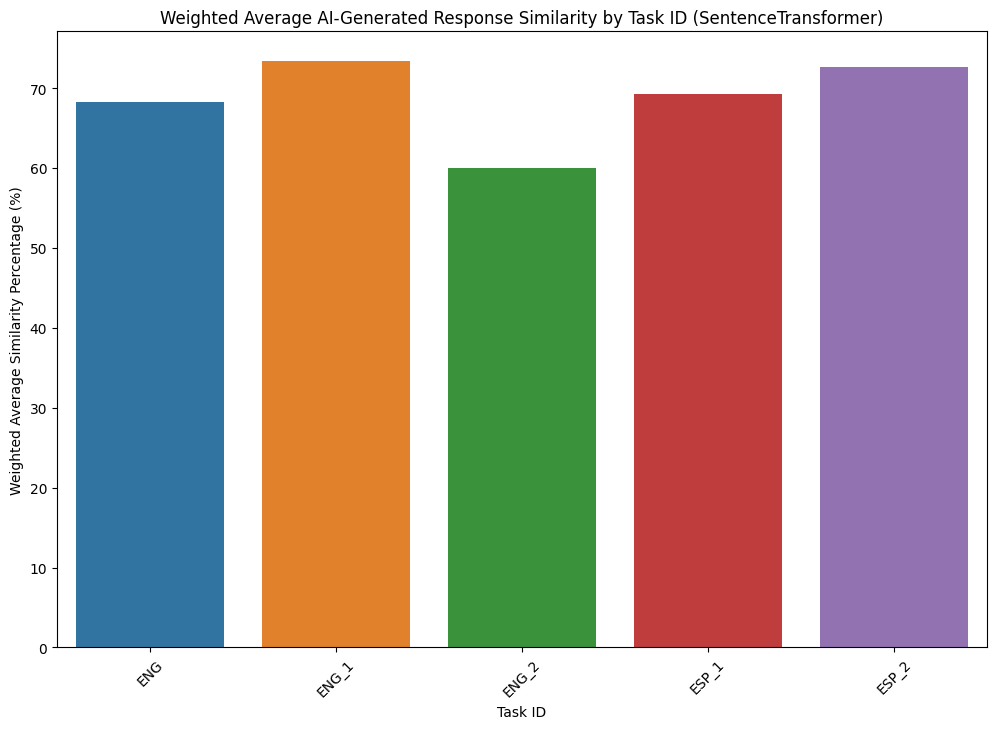

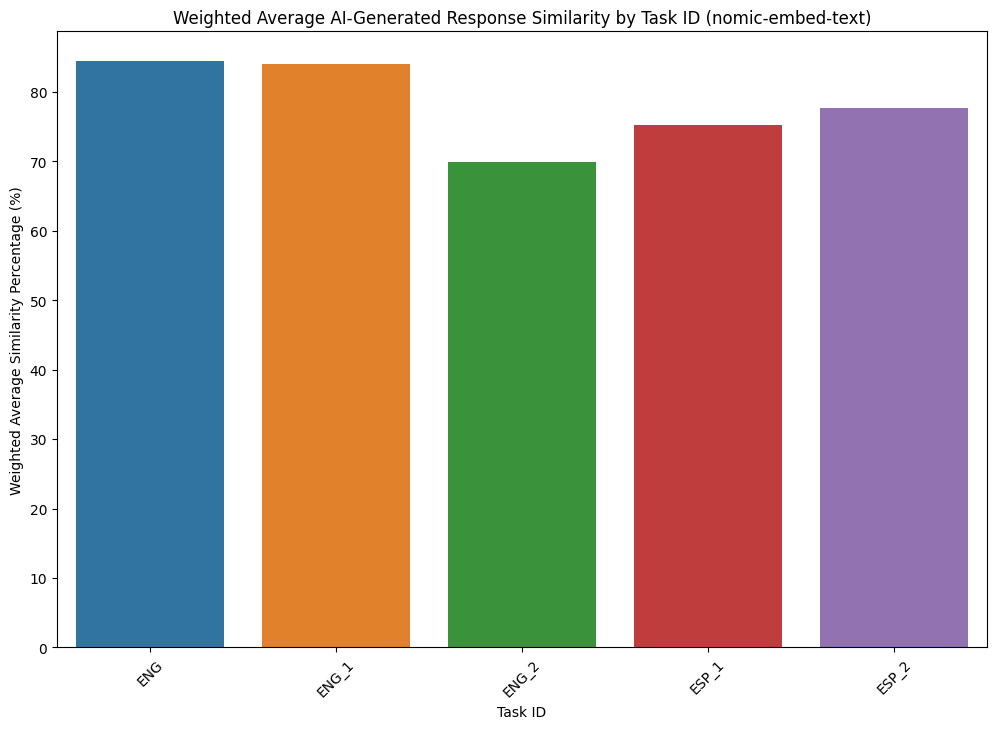

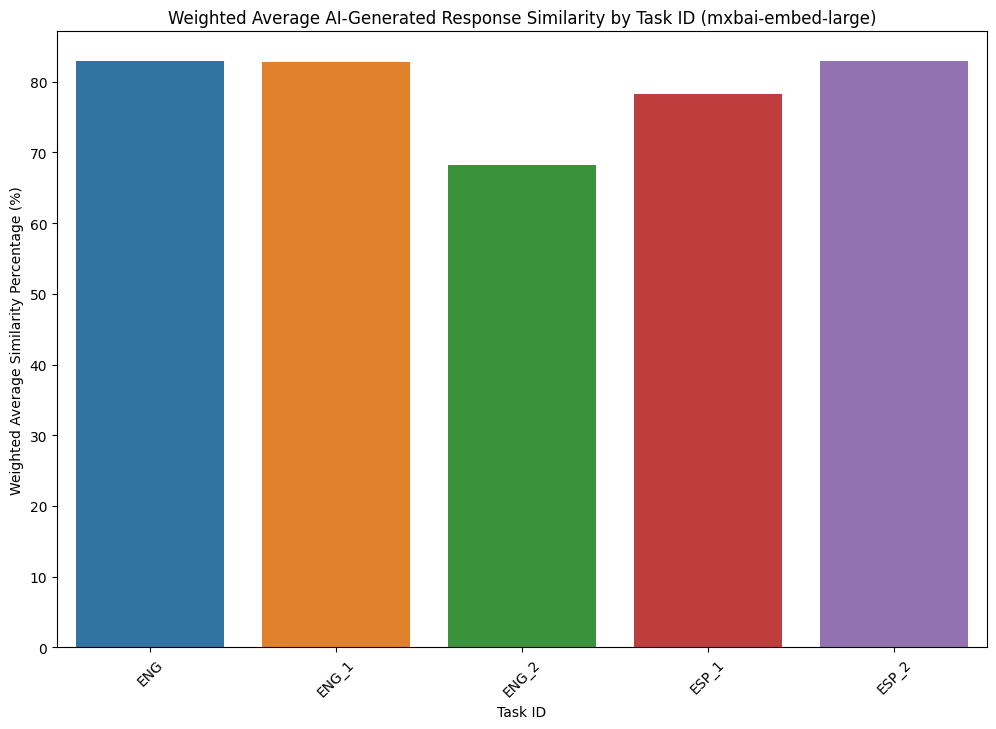

In [ ]:

results = []

for model_name, embed_function in models.items():
    # average_similarity_results = []
    weighted_similarity_results = []
    
    for _, row in content_usage.iterrows():
        plain_text = row['content']
        generated_content = row['generated']
        
        # Average similarity
        # avg_similarity = calculate_average_similarity(plain_text, generated_content, embed_function)
        # average_similarity_results.append(avg_similarity)
        
        # Weighted average similarity
        weighted_similarity = calculate_weighted_average_similarity(plain_text, generated_content, embed_function)
        weighted_similarity_results.append(weighted_similarity)
    
    # Store results in the DataFrame
    # content_usage[f'average_similarity_{model_name}'] = average_similarity_results
    content_usage[f'weighted_similarity_{model_name}'] = weighted_similarity_results

# Step 4: Plot the results

for model_name in models.keys():
    # Group by TASK_ID for both average and weighted similarities
    # grouped_avg_similarity = content_usage.groupby('TASK_ID')[f'average_similarity_{model_name}'].mean().reset_index()
    grouped_weighted_similarity = content_usage.groupby('TASK_ID')[f'weighted_similarity_{model_name}'].mean().reset_index()
    
    # # Plot Average Similarity
    # plt.figure(figsize=(12, 8))
    # sns.barplot(x='TASK_ID', y=f'average_similarity_{model_name}', data=grouped_avg_similarity, errorbar="sd")
    # plt.title(f'Average AI-Generated Response Similarity by Task ID ({model_name})')
    # plt.ylabel('Average Similarity Percentage (%)')
    # plt.xlabel('Task ID')
    # plt.xticks(rotation=45)
    # plt.show()
    
    # Plot Weighted Average Similarity
    plt.figure(figsize=(12, 8))
    sns.barplot(x='TASK_ID', y=f'weighted_similarity_{model_name}', data=grouped_weighted_similarity, errorbar="sd")
    plt.title(f'Weighted Average AI-Generated Response Similarity by Task ID ({model_name})')
    plt.ylabel('Weighted Average Similarity Percentage (%)')
    plt.xlabel('Task ID')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
content_usage

,_id_x,document_id,task_id,prolific_id,activity_log,time_spent_outside,timestamp,study_id,TASK_ID,_id_y,content,word_count,generated,average_similarity_SentenceTransformer,average_similarity_nomic-embed-text,average_similarity_mxbai-embed-large,weighted_similarity_SentenceTransformer,weighted_similarity_nomic-embed-text,weighted_similarity_mxbai-embed-large
0,66c5a24c86c57a87db6f59e3,66c5a13c86c57a87db6f59d9,main_task_1,5a4ff22bacc75b000179b0e9,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:16:12.414000+00:00,66c516b1d61c7b572205f713,ENG,66c5a13c86c57a87db6f59d9,Join hands with us in protecting our planet's ...,176,"[{'feature': '@ai generation', 'prompt': 'writ...",70.029593,89.614906,84.837552,83.504927,94.214644,91.414037
1,66c5e8072f44d7b54f76e537,66c5e4be2f44d7b54f76e52d,main_task_1,5c068f1f9d0df40001e5688c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 13:13:43.830000+00:00,66c516b1d61c7b572205f713,ENG,66c5e4be2f44d7b54f76e52d,In a time of uncertainty for the future of our...,153,[{'feature': 'Cautionary Narrative with Statis...,80.235922,91.993370,88.175350,80.267797,92.153723,88.233595
2,66c5a2ec86c57a87db6f59ed,66c5a21086c57a87db6f59e1,main_task_1,5c62de3f48fe4e000180e09d,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:18:52.061000+00:00,66c516b1d61c7b572205f713,ENG,66c5a21086c57a87db6f59e1,We are at a critical juncture where our inacti...,268,"[{'feature': '@ai generation', 'prompt': 'plea...",58.656162,84.161659,81.103999,60.899333,86.708230,84.661196
3,66c88800e46942c099b32394,66c88773e46942c099b32393,main_task_1,5d1f9776676cd1001580ae9c,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-23 13:00:48.591000+00:00,66c516b1d61c7b572205f713,ENG,66c88773e46942c099b32393,As you consider donating to the World Wildlife...,137,"[{'feature': '@ai generation', 'prompt': 'use ...",86.615533,91.480706,91.873540,87.157038,90.322942,91.402341
4,66c5a5c486c57a87db6f5a00,66c5a3e386c57a87db6f59f9,main_task_1,5ea9a41b87b4150bf9634637,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-21 08:31:00.305000+00:00,66c516b1d61c7b572205f713,ENG,66c5a3e386c57a87db6f59f9,\n\nThe World Wildlife Fund (WWF) is a beacon ...,146,"[{'feature': '@ai generation', 'prompt': ' ﻿Wr...",87.824714,91.788364,90.142630,88.710659,94.461373,92.429228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,66c7208e6db9c208f260cb6b,66c71e1a6db9c208f260cb58,main_task_1,66ad3809e453f7b457f7d048,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 11:27:10.356000+00:00,66c63f502b78911af098063d,ENG_2,66c71e1a6db9c208f260cb58,The World Wildlife Fund (WWF) is an internatio...,137,"[{'feature': '@ai generation', 'prompt': 'writ...",75.379795,84.286235,82.705458,82.879859,89.363740,87.751780
76,66c74f856db9c208f260cc0f,66c74f216db9c208f260cc0c,main_task_2,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE VARIATION...,0,2024-08-22 14:47:33.899000+00:00,66c63f502b78911af098063d,ESP_1,66c74f216db9c208f260cc0c,"Estimados amigos y ciudadanos, En estos moment...",103,"[{'feature': '@ai generation', 'prompt': 'crea...",87.449163,91.084698,94.760283,84.138551,88.786639,93.135608
77,66c7519f6db9c208f260cc1c,66c750f16db9c208f260cc18,main_task_1,60c101e4634ffb1aa797b924,{'buttonClicks': [{'action': 'CREATE CONTINUAT...,0,2024-08-22 14:56:31.836000+00:00,66c63f502b78911af098063d,ENG_2,66c750f16db9c208f260cc18,"By supporting our donation drive, you will not...",331,"[{'feature': 'continuation', 'prompt': 'Suppor...",63.222337,80.675783,77.454072,60.410321,85.802482,83.196747
78,66c758d46db9c208f260cc33,66c757f06db9c208f260cc32,main_task_2,6549030c68f0146d7216bb1c,"{'buttonClicks': [], 'generatedContent': [], '...",0,2024-08-22 15:27:16.063000+00:00,66c63f502b78911af098063d,ESP_1,66c757f06db9c208f260cc32,¡Únete a Nosotros para Proteger Nuestro Planet...,160,[],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
content_usage.to_csv('./content_usage_master.csv',index=False)

In [50]:
content_usage = pd.read_csv('./content_usage_master.csv')

In [49]:
avg_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'average_similarity_SentenceTransformer',
        'average_similarity_nomic-embed-text',
        'average_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Average Similarity (%)'
)

# Melt the DataFrame to long format for weighted average similarity
weighted_similarity_df = pd.melt(
    content_usage,
    id_vars=['TASK_ID'],
    value_vars=[
        'weighted_similarity_SentenceTransformer',
        'weighted_similarity_nomic-embed-text',
        'weighted_similarity_mxbai-embed-large'
    ],
    var_name='Model',
    value_name='Weighted Average Similarity (%)'
)

# Clean up the 'Model' column to only contain the model names

avg_similarity_df['Model'] = avg_similarity_df['Model'].str.replace('average_similarity_', '')
weighted_similarity_df['Model'] = weighted_similarity_df['Model'].str.replace('weighted_similarity_', '')


avg_similarity_df =  avg_similarity_df[avg_similarity_df['TASK_ID']!='ENG_No_LLM']
weighted_similarity_df =  weighted_similarity_df[weighted_similarity_df['TASK_ID']!='ENG_No_LLM']

avg_similarity_df = avg_similarity_df.groupby(['TASK_ID','Model'])['Average Similarity (%)'].mean().reset_index()
weighted_similarity_df = weighted_similarity_df.groupby(['TASK_ID','Model'])['Weighted Average Similarity (%)'].mean().reset_index()

# Step 2: Plot using Plotly

# Plot Average Similarity
fig_avg = px.bar(
    avg_similarity_df,
    x='TASK_ID',
    y='Average Similarity (%)',
    color='Model',
    title='Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group'
)
fig_avg.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_avg.show()
fig_avg.write_image('../figures/results/content_similarity_avg.pdf')
# Plot Weighted Average Similarity
fig_weighted = px.bar(
    weighted_similarity_df,
    x='TASK_ID',
    y='Weighted Average Similarity (%)',
    color='Model',
    title='Weighted Average AI-Generated Response Similarity by Task ID',
    labels={'TASK_ID': 'Task ID'},
    barmode='group'
)
fig_weighted.update_layout(
    xaxis_title='Task ID',
    yaxis_title='Weighted Average Similarity Percentage (%)',
    width=900,
    height=600
)
fig_weighted.show()
fig_weighted.write_image('../figures/results/content_similarity_weighted.pdf')


In [51]:
avg_similarity_df

,TASK_ID,Model,Average Similarity (%)
0,ENG,SentenceTransformer,62.681074
1,ENG,mxbai-embed-large,79.255143
2,ENG,nomic-embed-text,81.630770
3,ENG_1,SentenceTransformer,71.331720
4,ENG_1,mxbai-embed-large,80.174564
5,ENG_1,nomic-embed-text,81.851427
6,ENG_2,SentenceTransformer,56.619326
7,ENG_2,mxbai-embed-large,65.520872
8,ENG_2,nomic-embed-text,67.157735
9,ESP_1,SentenceTransformer,66.535909


In [54]:
pivot_df

Model,SentenceTransformer,mxbai-embed-large,nomic-embed-text
TASK_ID,,,
ENG,62.681074,79.255143,81.630770
ENG_1,71.331720,80.174564,81.851427
ENG_2,56.619326,65.520872,67.157735
ESP_1,66.535909,77.296365,74.495247
ESP_2,65.541533,79.183143,74.251394


In [53]:
pivot_df = avg_similarity_df.pivot(index='TASK_ID', columns='Model', values='Average Similarity (%)')

# Calculate the differences across TASK_IDs for each model
differences = pivot_df.diff().dropna()
differences

Model,SentenceTransformer,mxbai-embed-large,nomic-embed-text
TASK_ID,,,
ENG_1,8.650647,0.919421,0.220657
ENG_2,-14.712394,-14.653692,-14.693691
ESP_1,9.916583,11.775493,7.337512
ESP_2,-0.994377,1.886778,-0.243853


In [56]:
pivot_df

Model,SentenceTransformer,mxbai-embed-large,nomic-embed-text
TASK_ID,,,
ENG,62.681074,79.255143,81.630770
ENG_1,71.331720,80.174564,81.851427
ENG_2,56.619326,65.520872,67.157735
ESP_1,66.535909,77.296365,74.495247
ESP_2,65.541533,79.183143,74.251394


In [57]:
pivot_df = avg_similarity_df.pivot(index='TASK_ID', columns='Model', values='Average Similarity (%)')

# Calculate pairwise differences
eng_diff = pivot_df.loc['ENG_1'] - pivot_df.loc['ENG_2']
esp_diff = pivot_df.loc['ESP_1'] - pivot_df.loc['ESP_2']

# Combine the differences into a DataFrame for display
differences = pd.DataFrame({'ENG_1 - ENG_2': eng_diff, 'ESP_1 - ESP_2': esp_diff, 'ENG': pivot_df.loc[['ENG', '']]})

# Display the differences
differences

,ENG_1 - ENG_2,ESP_1 - ESP_2,ENG
Model,,,
SentenceTransformer,14.712394,0.994377,62.681074
mxbai-embed-large,14.653692,-1.886778,79.255143
nomic-embed-text,14.693691,0.243853,81.630770
